In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Dataset

In [2]:
df = pd.read_csv('./data/AMZN.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


array([  47.58,   47.25,   47.65, ..., 1182.26, 1186.1 , 1169.47])

SHAPE:  (3019,)


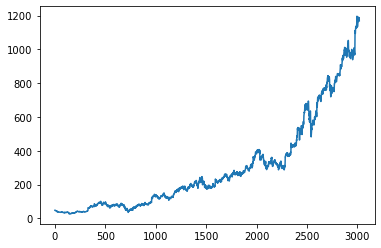

In [3]:
prices = df['Close'].values

display(prices)
print("SHAPE: ",prices.shape)
plt.plot(prices)
plt.show()

# LSTM & GRU Parameters & Data Flow

- LSTM & GRU params:
    1. `seq_length` - *[NOT PART OF LSTM/GRU] - length of a single sequence of inputs*
    2. `n_features` - *Number of features/variables in single input*
    3. `n_hidden`   - *Number of hidden nodes in a single LSTM/GRU layer*
    4. `n_layers`   - *Number of stacked LSTM/GRU layers*

- Data Flow Protocol:
    1. `network input shape` - (batch_size, seq_length, n_features)
    2. `LSTM output shape`   - (batch_size, seq_length, n_hidden)
    3. `Linear input shape`  - (batch_size * seq_length, n_hidden)
    4. `Linear output`       - (batch_size * seq_length, out_size)

In [4]:
class Parameters:
    SEQ_LENGTH = 20
    N_FEATURES = 1    # using only 1 column
    N_HIDDEN = 32
    N_LAYERS = 2
    OUT_SIZE = 1
    BATCH_SIZE = None # unused
    NUM_EPOCHS = 100

## Preprocess Data

In [5]:
#data preprocess
def split_data(data_raw, seq_len):
    '''
    data_raw - (np array) shape - (num_samples, n_features)
    seq_len - (int) sequence length [20]
    '''
    data = []
    
    # create all possible sequences of length seq_len(lookback)
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return (x_train, y_train, x_test, y_test)

In [6]:
# SCALE FROM -1 to 1 FOR SCALED LOSSES
scaler = MinMaxScaler(feature_range=(-1, 1))
prices = scaler.fit_transform(np.expand_dims(prices, axis=1)).reshape(-1)

# CREATE TRAIN & TEST SET
prices = np.expand_dims(prices, axis=1) #NUM_FEATURES = 1(single column), EXPECTED SHAPE: (num_samples, num_features) [(3019,) -> (3019,1)]
print("DATA SHAPE: ", prices.shape)

x_train, y_train, x_test, y_test = split_data(data_raw = prices,
                                              seq_len = Parameters.SEQ_LENGTH)
print("X_TRAIN: ", x_train.shape)
print("Y_TRAIN: ", y_train.shape)
print("X_TEST : ", x_test.shape)
print("Y_TEST : ", y_test.shape)

DATA SHAPE:  (3019, 1)
X_TRAIN:  (2399, 19, 1)
Y_TRAIN:  (2399, 1)
X_TEST :  (600, 19, 1)
Y_TEST :  (600, 1)


In [7]:
#TO TENSORS
x_train = T.tensor(x_train, dtype=T.float32)
y_train = T.tensor(y_train, dtype=T.float32)
x_test = T.tensor(x_test, dtype=T.float32)
y_test = T.tensor(y_test, dtype=T.float32)

## LSTM Network

In [8]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers, out_size):
        super().__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.out_size = out_size
        # LAYERS
        self.lstm = nn.LSTM(n_features, n_hidden, n_layers, batch_first=True)
        self.fc = nn.Linear(n_hidden, out_size)
        # UTILS
        self.optimizer = optim.Adam(self.parameters(), lr=0.01)
        self.loss = nn.MSELoss()
        
    def forward(self, t):
        h0 = T.zeros(self.n_layers, t.size(0), self.n_hidden).requires_grad_()
        c0 = T.zeros(self.n_layers, t.size(0), self.n_hidden).requires_grad_()
        # FWD PROP
        t, (hn, cn) = self.lstm(t, (h0.detach(), c0.detach()))
        out = self.fc(t[:,-1,:])
        return out

In [9]:
#NETWORK
model = LSTM(n_features=Parameters.N_FEATURES,
             n_hidden=Parameters.N_HIDDEN,
             n_layers=Parameters.N_LAYERS,
             out_size=Parameters.OUT_SIZE)

In [10]:
# TRAINING
losses = []

for epoch_n in tqdm(range(Parameters.NUM_EPOCHS)):
    y_pred = model(x_train)
    
    loss = model.loss(y_pred, y_train)
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    
    if(epoch_n%5 == 0):
        print(f"EPOCH: {epoch_n}  LOSS: {loss.item()}")
    losses.append(loss.item())

EPOCH: 0  LOSS: 0.3994198739528656
EPOCH: 5  LOSS: 0.043228354305028915
EPOCH: 10  LOSS: 0.04917304590344429
EPOCH: 15  LOSS: 0.0401153601706028
EPOCH: 20  LOSS: 0.031463392078876495
EPOCH: 25  LOSS: 0.032215047627687454
EPOCH: 30  LOSS: 0.02703743614256382
EPOCH: 35  LOSS: 0.018986618146300316
EPOCH: 40  LOSS: 0.005717363208532333
EPOCH: 45  LOSS: 0.0039036220405250788
EPOCH: 50  LOSS: 0.0020991023629903793
EPOCH: 55  LOSS: 0.001668083481490612
EPOCH: 60  LOSS: 0.0006266005802899599
EPOCH: 65  LOSS: 0.0009527470683678985
EPOCH: 70  LOSS: 0.00043303094571456313
EPOCH: 75  LOSS: 0.0004808834055438638
EPOCH: 80  LOSS: 0.0003385466698091477
EPOCH: 85  LOSS: 0.00036770504084415734
EPOCH: 90  LOSS: 0.00029282530886121094
EPOCH: 95  LOSS: 0.0002997791743837297



## Evaluate LSTM

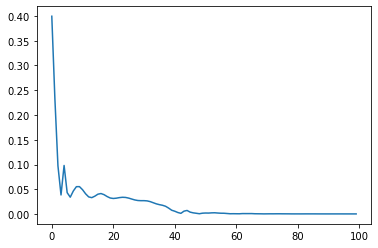

In [11]:
# LOSS CURVE
plt.plot(losses)

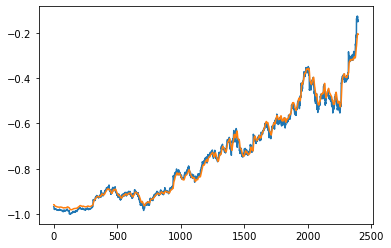

In [12]:
# TRAIN SET PREDS
y_pred = model(x_train)

plt.plot(y_train)         # true        
plt.plot(y_pred.detach()) # pred

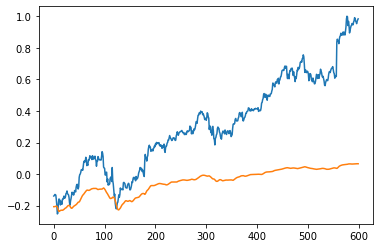

In [14]:
# GET TEST SET PREDS

y_pred = model(x_test)

plt.plot(y_test)          # true
plt.plot(y_pred.detach()) # pred

## GRU Network

In [15]:
class GRU(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers, out_size):
        super().__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.out_size = out_size
        # LAYERS
        self.gru = nn.GRU(n_features, n_hidden, n_layers, batch_first=True)
        self.fc = nn.Linear(n_hidden, out_size)
        # UTILS
        self.optimizer = optim.Adam(self.parameters(), lr=0.01)
        self.loss = nn.MSELoss()
        
    def forward(self, t):
        h0 = T.zeros(self.n_layers, t.size(0), self.n_hidden).requires_grad_()
        # FWD PROP
        t, (hn) = self.gru(t, (h0.detach()))
        out = self.fc(t[:,-1,:])
        return out

In [16]:
#NETWORK
model = GRU(n_features=Parameters.N_FEATURES,
            n_hidden=Parameters.N_HIDDEN,
            n_layers=Parameters.N_LAYERS,
            out_size=Parameters.OUT_SIZE)

In [17]:
# TRAINING
losses = []

for epoch_n in tqdm(range(Parameters.NUM_EPOCHS)):
    y_pred = model(x_train)
    
    loss = model.loss(y_pred, y_train)
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    
    if(epoch_n%5 == 0):
        print(f"EPOCH: {epoch_n}  LOSS: {loss.item()}")
    losses.append(loss.item())

EPOCH: 0  LOSS: 0.5725619792938232
EPOCH: 5  LOSS: 0.026372745633125305
EPOCH: 10  LOSS: 0.029836660251021385
EPOCH: 15  LOSS: 0.02829795889556408
EPOCH: 20  LOSS: 0.02546306699514389
EPOCH: 25  LOSS: 0.013853787444531918
EPOCH: 30  LOSS: 0.006436438299715519
EPOCH: 35  LOSS: 0.0014872632455080748
EPOCH: 40  LOSS: 0.001191148185171187
EPOCH: 45  LOSS: 0.0021249421406537294
EPOCH: 50  LOSS: 0.00045171842793934047
EPOCH: 55  LOSS: 0.0003765291767194867
EPOCH: 60  LOSS: 0.0003266755666118115
EPOCH: 65  LOSS: 0.00020787818357348442
EPOCH: 70  LOSS: 0.00023441483790520579
EPOCH: 75  LOSS: 0.0001944779505720362
EPOCH: 80  LOSS: 0.0001245740568265319
EPOCH: 85  LOSS: 0.00013565961853601038
EPOCH: 90  LOSS: 0.0001337374997092411
EPOCH: 95  LOSS: 0.00011354836169630289



## Evaluate GRU

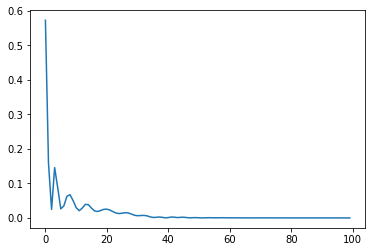

In [18]:
# LOSS CURVE
plt.plot(losses)

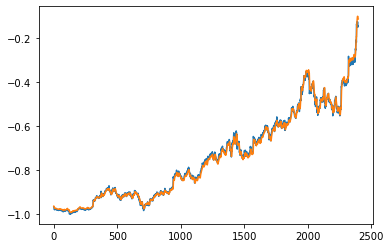

In [19]:
# TRAIN SET PREDS
y_pred = model(x_train)

plt.plot(y_train)         # true        
plt.plot(y_pred.detach()) # pred

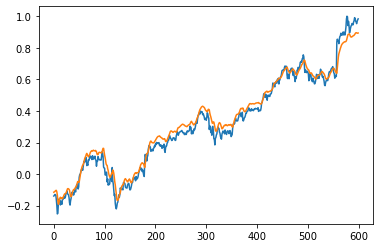

In [20]:
# GET TEST SET PREDS

y_pred = model(x_test)

plt.plot(y_test)          # true
plt.plot(y_pred.detach()) # pred